# Prophet

* https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import torch

from data   import standarizer, \
                   features_target_split, \
                   train_test_split

import pytorch_common.util    as pu
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


## Setup

In [4]:
sns.set(rc = {'figure.figsize':(15,8)})

In [5]:
CFG = {
    'etherium': { 'path': '../datasets/ETH_1H.csv',                 'variable': 'close' },
    'min-temp': { 'path': '../datasets/daily-min-temperatures.csv', 'variable': 'temp'  },
    'dataset' : 'min-temp',
    'interval_width'   : 0.99, 
    'daily_seasonality': True,
    'times'   : 200
}

## Functions

In [6]:
def normalize(train_set, test_set):
    norm_train_set, norm_test_set = standarizer(train_set, test_set, columns=['y'])
    
    norm_train_set = norm_train_set[['ds', 'norm_y']]
    norm_train_set = norm_train_set.rename(columns={'norm_y': 'y' }).sort_values(by='ds',ascending=True)
    
    norm_test_set = norm_test_set[['ds', 'norm_y']]
    norm_test_set = norm_test_set.rename(columns={'norm_y': 'y' }).sort_values(by='ds',ascending=True)

    return norm_train_set, norm_test_set


def select_and_format_columns(dataset, column):
    dataset.columns = dataset.columns.str.lower()
    dataset       = dataset[['date', column]]
    dataset       = dataset.rename(columns={'date': 'ds', column: 'y' })
    dataset['ds'] = pd.to_datetime(dataset['ds'])
    dataset       = dataset.sort_values(by='ds',ascending=True)
    return dataset


def preprocessing(dataset, column, test_percent):
    dataset                       = select_and_format_columns(dataset, column)
    train_set, test_set           = train_test_split(dataset, test_percent = test_percent)
    norm_train_set, norm_test_set = normalize(train_set, test_set)

    print(norm_train_set.shape, norm_test_set.shape)

    return norm_train_set, norm_test_set

In [7]:
def predict(model, y_true_df, times):
    y_true_df = y_true_df.head(times)

    y_pred_df = model.predict(y_true_df[['ds']])

    predictions_df = y_true_df.merge(y_pred_df, on='ds')
    predictions_df = predictions_df[['ds', 'y', 'yhat']]
    predictions_df = predictions_df.sort_values(by='ds',ascending=True)
    
    plot(
        predictions_df.yhat.values,
        predictions_df.y.values
    )
    model.plot(y_pred_df)

In [8]:
def plot(y_pred, y_true):
    sns.set_style("darkgrid")
    plt.plot(y_true, color='green',label="True")        
    plt.plot(y_pred, color='blue', label="Prediction")
    plt.legend()
    plt.show()

## Preprocessing

In [9]:
train_set, test_set = preprocessing(
    dataset      = pd.read_csv(CFG[CFG['dataset']]['path']),     
    column       = CFG[CFG['dataset']]['variable'], 
    test_percent = 0.1
)

(3285, 2)
(365, 2)

# Model Definition

10:54:03 - cmdstanpy - INFO - Chain [1] start processing
10:54:04 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1080x576 with 1 Axes>

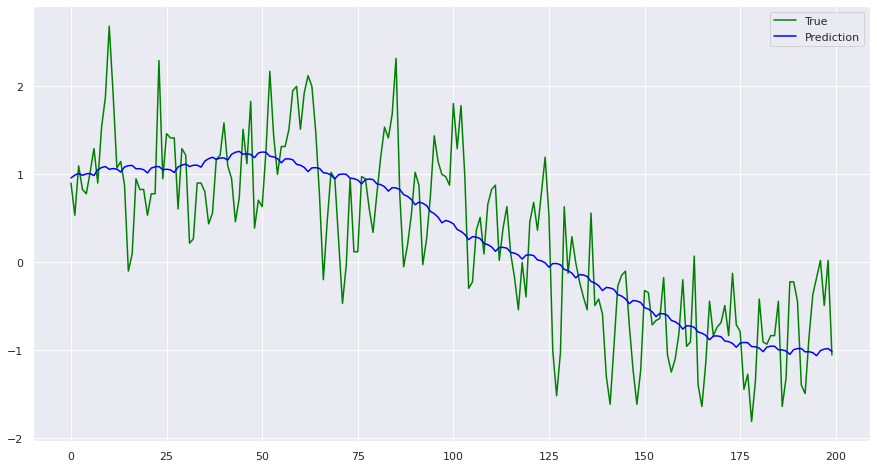

<Figure size 720x432 with 1 Axes>

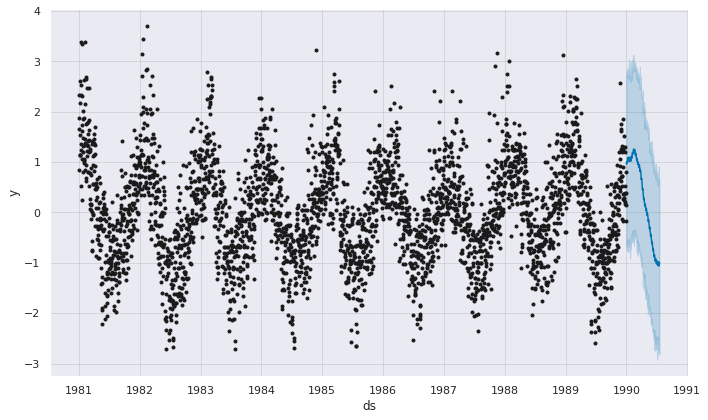

In [10]:
model = Prophet(
    interval_width    = CFG['interval_width'],
    daily_seasonality = CFG['daily_seasonality']
)
model.fit(train_set)
predict(model, test_set, times=CFG['times'])